# Modelo de respuesta binaria: regresión logística

Módulo 2 - Elementos de probabilidad y estadística

Facultad de Ciencias Exactas y Naturales y Agrimensura (FaCENA) - UNNE

Diplomatura Universitaria en Ciencia de Datos

Profesores:
* Lic. Álvarez Fernando fernando.alvarez@comunidad.unne.edu.ar
* Lic. Cabás Celine celine.cabas@comunidad.unne.edu.ar
* Dr. Hisgen Matías matias.hisgen@comunidad.unne.edu.ar

\

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt          # Para gráficos
import seaborn as sns                    # Para gráficos
import scipy.stats as stats              # Para calcular funciones de densidad
import statsmodels.api as sm             # Para modelos
import statsmodels.formula.api as smf    # Para regresión logística
from scipy.stats import chi2_contingency # Test de independencia
from imblearn.over_sampling import SMOTE # Remuestreo
from sklearn import metrics              # Matriz de confusión y otras medidas de clasif
from sklearn.model_selection import train_test_split # Dividir datos en entrenamiento y test
#import os

# Modelos de respuesta binaria

Cuando la variable que queremos explicar (o predecir) es binaria, es decir asume valores 0 y 1, modelamos la probabilidad de ocurrencia del suceso que mide esta variable. Este problema podemos abordarlo:

1. Como en las prácticas vistas anteriormente, mediante el ajuste de un **modelo de regresión lineal** por Mínimos Cuadrados Ordinarios con statsmodels.OLS() pero en este caso con una variable de respuesta binaria. Este modelo tiene ciertas ventajas y desventajas. Es simple de interpretar y comunicar resultados porque los coeficientes $\beta$ ajustados son directamente interpretables, pero puede predecir probabilidades mayores a 1 o menores a 0 en los extremos y estima efectos marginales constantes lo cual puede no ser útil siempre. Son conocidos como Modelos Lineales de Probabilidad (MLP).

2. Con **modelos de regresión logísticos**, que admiten distribuciones asociadas a las variables binarias distintas a la normal y son ajustados por Máxima Verosimilitud.

# Regresión logística

La regresión logística estima la probabilidad de que ocurra un evento condicionado a un conjunto de variables independientes. Asume que la variable binaria a modelar proviene de una distribución Binomial (Bernoulli). Este modelo forma parte de la familia de los Modelos Lineales Generalizados (MLG) que extienden al Modelo Lineal Clásico visto en las prácticas anteriores admitiendo distribuciones diferentes a la normal y modelando *funciones* de los parámetros que nos interesan.

En logísticos, nos interesa modelar la probabilidad de ocurrencia de un evento (parámetro $p$ de una Bernoulli) condicionado a variables explicativas. Para ello, el modelo tranforma la probabilidad mediante la función de enlace logit con el objetivo de poder estimar una función lineal (o predictor lineal $\eta$).

1. $Y \sim B(1,p)$

2. $z=\beta_0+\beta_1x_1+\beta_2x_2...=x\beta$

3. $g(p)=logit(p)=logit(P(Y=1/x\beta))=z$

La función logit nos permite utilizar la función de distribución de acumulada de una variable aleatoria con distribución logística. Por lo tanto, para estimar las probabilidades predichas el modelo utiliza la función de densidad acumulada (fda) y para estimar efectos marginales la función de densidad de probabilidad (fdp).

FDA: $F(x)=\frac{exp(z)}{1+\exp(z)}$

FDP: $f(x)=\frac{exp(z)}{[1+exp(z)]^2}$

# Aplicación: Diabetes

Establecemos conexión a Google Drive para cargar la base de datos "Diabetes.xlsx"

In [2]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Nos posicionamos en el directorio donde esta la base
%cd '/content/drive/MyDrive/Diplomatura Ciencia de Datos FaCENA - Módulo 2'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1scPBK7RIOW7jmjjGCi452DkKLldnJd7A/Diplomatura Ciencia de Datos FaCENA - Módulo 2


Para setear localmente: descomentar y colocar su path en la siguiente instrucción:

In [ ]:
#os.chdir('')

Cargamos la base de datos:

In [3]:
datos = pd.read_excel("Bases/Diabetes.xlsx")
datos.head()

,ID,EDAD,SEXO,PESO,TALLA,DM,SEDENT,TAS,TAD,HTA_OMS,ECV_B,TABACO,ALCOHOL,STATIN,CINTURA,CADERA,OBCENT_ATP,COLEST
0,11,44,1,63.9,163.0,0,0,115.000,85,0,0,0,0,1,95.0,96,0,213
1,23,37,0,63.2,157.5,0,1,130.065,80,0,0,0,0,0,90.0,96,1,216
2,38,67,1,70.2,145.0,1,1,190.000,95,1,0,0,0,0,106.5,110,1,231
3,50,78,0,88.9,157.0,0,1,140.000,80,1,1,0,0,0,126.0,132,1,268
4,65,33,1,81.8,175.0,0,0,120.000,80,0,0,1,1,0,86.0,89,0,217


**Descripción de variables**

* EDAD: edad, expresada en años.
* SEXO: sexo, codificado con 0 para Hombres y 1 para Mujeres.
* PESO: peso, expresado en kilogramos.
* TALLA: talla, expresada en cm.
* DM: Indicadora de presencia de Diabetes Mellitus.
* SEDENT: indicadora de ser o no sedentario.
* TAS: Presión arterial sistólica, en mmHg.
* TAD: Presión arterial diastólica, en mmHg.
* HTA_OMS: Indicadora de padecer hipertensión arterial, según lo definido por la OMS.
* ECV_B: indicadora de padecer enfermedades cardiovasculares.
* TABACO: indicadora de ser fumador.
* ALCOHOL: indicadora de beber alcohol regularmente.
* STATIN: indicadora de consumo de Estanina (medicamento indicado para bajar
colesterol y triglicéridos)
* CINTURA: perímetro, expresado en cm.
* CADERA: perímetro, expresado en cm.
* OBCENT_ATP: indicadora de obesidad central.
* COLESTEROL: colesterol total, en md/dL.


## Análisis descriptivo

La variable que queremos modelar es la presencia de diabetes medida con la variable binaria 'DM'. Si vemos el conteo de casos en la muestra, además de contar con un número de observaciones un poco reducido, tenemos sólo 8 casos positivos con diabetes. Lo cual representa el 10% de las observaciones.

In [ ]:
datos['DM'].value_counts()

DM
0    72
1     8
Name: count, dtype: int64

In [ ]:
datos['DM'].value_counts(normalize=True)

DM
0    0.9
1    0.1
Name: proportion, dtype: float64

**Presencia de Diabetes Mellitus (DM) según variables numéricas**

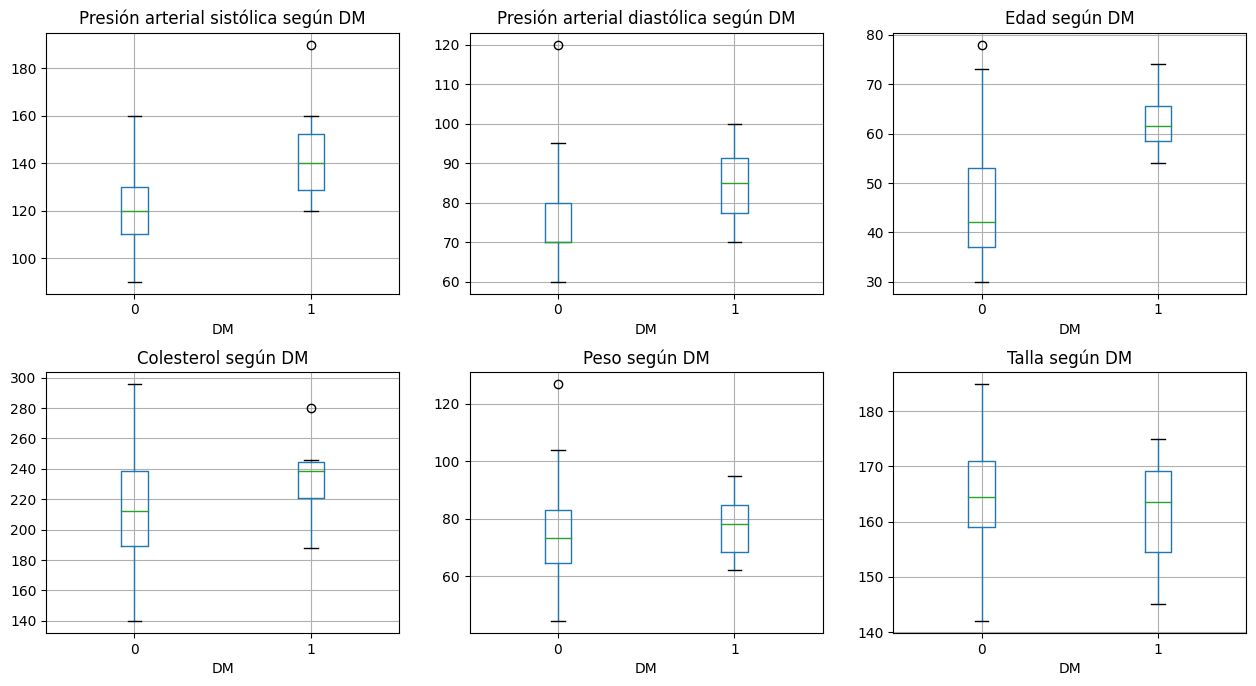

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(15, 8))

# Presión arterial sistólica según presencia o no de DM
datos.boxplot(column='TAS', by = 'DM', ax=ax[0,0])
ax[0,0].set_title("Presión arterial sistólica según DM")

# Presión arterial diastólica según presencia o no de DM
datos.boxplot(column='TAD', by = 'DM', ax=ax[0,1])
ax[0,1].set_title("Presión arterial diastólica según DM")

# Edad según presencia o no de DM
datos.boxplot(column='EDAD', by = 'DM', ax=ax[0,2])
ax[0,2].set_title("Edad según DM")

# Colesterol según presencia o no de DM
datos.boxplot(column='COLEST', by = 'DM', ax=ax[1,0])
ax[1,0].set_title("Colesterol según DM")

# Peso según presencia o no de DM
datos.boxplot(column='PESO', by = 'DM', ax=ax[1,1])
ax[1,1].set_title("Peso según DM")

# Talla según presencia o no de DM
datos.boxplot(column='TALLA', by = 'DM', ax=ax[1,2])
ax[1,2].set_title("Talla según DM")

fig.suptitle('')
plt.subplots_adjust(hspace=0.3)
plt.show()

**Presencia de Diabetes Mellitus (DM) según variables categóricas**

In [ ]:
pd.crosstab(datos['DM'],datos['HTA_OMS'], normalize=True, margins=True)

HTA_OMS,0,1,All
DM,,,
0,0.6625,0.2375,0.9
1,0.0125,0.0875,0.1
All,0.6750,0.3250,1.0


## Test de asociación $\chi^2$

El test chi-cuadrado nos permite determinar si existe independencia o no entre dos variable categóricas de mi conjunto de datos. Es decir, comprueba si estas variables están asociadas.

El estadístico $\chi^2$ se calcula con la siguiente fórmula, donde $f_e$
y $f_o$ son las frecuencias esperadas y frecuencias observadas,
respectivamente, $r$ es el número de filas de la tabla y $c$ el número
de columnas.

$$
\chi^2=\sum{\frac{(f_e-f_o)^2}{f_e} \sim \chi^2_{(r-1)(c-1)}}
$$

**Test: DM vs HTA_OMS**

$H_0:$ no existe asociación entre la presencia de diabetes y la presencia de hipertensión arterial.

$H_1:$ existe asociación entre la presencia de diabetes y la presencia de hipertensión arterial

In [ ]:
prueba_chi2 = chi2_contingency(pd.crosstab(datos['DM'],datos['HTA_OMS']))
print("Estadístico chi2 = ", prueba_chi2[0].round(4))
print("p-value = ", prueba_chi2[1].round(4))

Estadístico chi2 =  9.6296
p-value =  0.0019


Se rechaza la hipótesis nula, por lo cual tenemos evidencia de que existe asociación entre la presencia de diabetes y la hipertensión arterial.

**Test: DM vs TABACO**

$H_0:$ no existe asociación entre la presencia de diabetes y el consumo de tabaco.

$H_1:$ existe asociación entre la presencia de diabetes y el consumo de tabaco.

In [ ]:
prueba_chi2 = chi2_contingency(pd.crosstab(datos['DM'],datos['TABACO']))
print("Estadístico chi2 = ", prueba_chi2[0].round(4))
print("p-value = ", prueba_chi2[1].round(4))

Estadístico chi2 =  0.9117
p-value =  0.3397


No podemos rechazar la nula de que no existe asociación entre las variables.

**Test: DM vs SEDENT**

$H_0:$ no existe asociación entre la presencia de diabetes y que la persona sea sedentaria.

$H_1:$ existe asociación entre la presencia de diabetes y que la persona sea sedentaria.

In [ ]:
prueba_chi2 = chi2_contingency(pd.crosstab(datos['DM'],datos['SEDENT']))
print("Estadístico chi2 = ", prueba_chi2[0].round(4))
print("p-value = ", prueba_chi2[1].round(4))

Estadístico chi2 =  1.6096
p-value =  0.2046


No podemos rechazar la nula de que no existe asociación entre las variables.

**Test: DM vs OBCENT_ATP**

$H_0:$ no existe asociación entre la presencia de diabetes y la presencia de obesidad central.

$H_1:$ existe asociación entre la presencia de diabetes y la presencia de obesidad central.

In [ ]:
prueba_chi2 = chi2_contingency(pd.crosstab(datos['DM'],datos['OBCENT_ATP']))
print("Estadístico chi2 = ", prueba_chi2[0].round(4))
print("p-value = ", prueba_chi2[1].round(4))

Estadístico chi2 =  2.7041
p-value =  0.1001


No podemos rechazar la nula de que no existe asociación entre las variables.

## Modelos para inferencia

Nuestro objetivo es modelar la probabilidad de tener diabetes para los individuos de la muestra.

Como primer ajuste, incluimos como variable explicativa a la presión arterial sistólica (TAS) y vemos resultados.

In [ ]:
reg_log = smf.logit(formula='DM ~ TAS', data=datos).fit()
print(reg_log.summary())

Optimization terminated successfully.
         Current function value: 0.230497
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                     DM   No. Observations:                   80
Model:                          Logit   Df Residuals:                       78
Method:                           MLE   Df Model:                            1
Date:                Fri, 07 Jun 2024   Pseudo R-squ.:                  0.2910
Time:                        21:05:06   Log-Likelihood:                -18.440
converged:                       True   LL-Null:                       -26.007
Covariance Type:            nonrobust   LLR p-value:                 0.0001002
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -14.1996      4.163     -3.411      0.001     -22.358      -6.041
TAS            0.0927      0.

De la salida anterior debemos tener en cuenta que sólo podemos interpretar el signo del coeficiente asociado a la variable TAS, es decir su dirección positiva en este caso. El valor del coeficiente no es directamente interpretable como efecto marginal dado que el modelo estima una **función** (intermedia) de la probabilidad. Para llegar a obtener las probabilidades predichas, los valores ajustados requieren ser evaluados en la fdp logística. Esto podemos hacerlo automáticamente con la función predict() que nos calcula las probabilidades predichas.

*Método: MLE hace referencia a Maximun likelihood estimation

Vemos gráficamente el ajuste del modelo, ya que estamos trabajando con una sola variable explicativa:

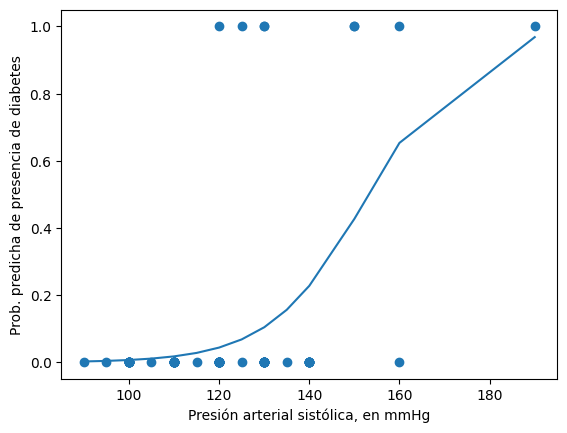

In [ ]:
datos.sort_values(by='TAS', inplace=True)
datos['predichos'] = reg_log.predict(datos)

plt.scatter(datos['TAS'], datos['DM'])
plt.plot(datos['TAS'], datos['predichos'])
plt.xlabel('Presión arterial sistólica, en mmHg')
plt.ylabel('Prob. predicha de presencia de diabetes')
plt.show()

### Interpretación de coeficientes

**1) Efectos marginales**

Podemos calcular el efecto marginal de un aumento en la presión arterial sobre la probabilidad de que la persona tenga diabetes. En los modelos logísticos, a diferencia de los modelos lineales vistos anteriormente, este efecto no es interpretable directamente de la salida anterior. Debemos calcularlo, generalizando al caso de cualquier variable explicativa $x_j$ :

$$\frac{\partial p}{\partial x_j}=f(z)\beta_j$$

donde $f()$ es la función de densidad de probabilidad (fdp, o simplemente densidad) de una variable logística.

Alternativa de cálculo 1

In [ ]:
z_media = reg_log.fittedvalues # Valores ajustados de z
efecto_marginal = stats.logistic.pdf(z_media)*reg_log.params.values[1] # Efecto marginal de TAD
efecto_marginal.mean()

0.00602107878853861

Alternativa de cálculo 2

In [ ]:
z_mediax = reg_log.params.values[0] + reg_log.params.values[1]*(datos['TAS'].mean()) # Valores ajustados de z
efecto_marginal = stats.logistic.pdf(z_mediax)*reg_log.params.values[1] # Efecto marginal de TAD
efecto_marginal

0.0043480848016673726

Del cálculo anterior tenemos que por cada aumento en una unidad (en mmHg) de presión arterial sistólica, la probabilidad de que la persona tenga diabetes aumenta en 0.006 en promedio. Este coeficiente se asemeja a los que analizamos directamente de las salidas anteriormente cuando ajustabamos modelos lineales clásicos por MCO.

**2) Odds ratio (coeficientes de chance)**

También podemos expresar los coeficientes del modelo en términos de coeficientes de chance (también llamados cociente de probabilidades):

$$Odds ratio = \frac{\hat{p}}{1-\hat{p}}=exp(\hat{\beta}_1)$$

In [ ]:
odds_ratios = pd.DataFrame({"OR": reg_log.params,                # Odds Ratio (Coeficiente de chance)
                            "LimInf IC": reg_log.conf_int()[0],  # Límite inferior del intervalo de confianza
                            "LimSup IC": reg_log.conf_int()[1]}) # Límite superior del intervalo de confianza
odds_ratios = round(np.exp(odds_ratios),4)
print(odds_ratios)

               OR  LimInf IC  LimSup IC
Intercept  0.0000     0.0000     0.0024
TAS        1.0971     1.0328     1.1655


Por cada aumento en un mmHg de presión arterial, la chance de que la persona presente la enfermedad de Diabetes Mellitus aumenta en un 8.10%. Dado que los efectos marginales no son constantes en estos modelos, suelen usarse estos coeficientes para interpretar direcciones y magnitudes de los efectos.

### Con variable binaria explicativa

En base a lo que observamos en el análisis descriptivo, podemos incluir otras variables:

In [ ]:
reg_log = smf.logit(formula='DM ~ TAS + EDAD + HTA_OMS', data=datos).fit()
print(reg_log.summary())

Optimization terminated successfully.
         Current function value: 0.204354
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                     DM   No. Observations:                   80
Model:                          Logit   Df Residuals:                       76
Method:                           MLE   Df Model:                            3
Date:                Sat, 08 Jun 2024   Pseudo R-squ.:                  0.3714
Time:                        02:19:24   Log-Likelihood:                -16.348
converged:                       True   LL-Null:                       -26.007
Covariance Type:            nonrobust   LLR p-value:                 0.0002351
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -13.3761      4.766     -2.807      0.005     -22.717      -4.035
TAS            0.0572      0.

La significatividad estadística de la variable 'TAS' cae, además de que las otras variables tampoco son detectadas como influyentes en el modelo. Esto puede deberse a que existe correlación entre las variables lo cual produce multicolinealidad además de que estamos trabajando con un tamaño muestral relativamente chico, con pocos casos de diabetes.

La variable HTA_OMS indica la presencia de hipertensión arterial, por lo tanto tiene alta correlación con TAS. Podemos pensar en un modelo que incluya sólo una de ellas.


In [ ]:
datos[['TAS','EDAD','HTA_OMS']].corr()

,TAS,EDAD,HTA_OMS
TAS,1.000000,0.472909,0.615176
EDAD,0.472909,1.000000,0.459976
HTA_OMS,0.615176,0.459976,1.000000


Para poder analizar los coeficientes cuando tenemos una variable explicativa binaria, planteamos el siguiente modelo alternativo:

In [ ]:
reg_log = smf.logit(formula='DM ~ HTA_OMS + EDAD', data=datos).fit()
print(reg_log.summary())

Optimization terminated successfully.
         Current function value: 0.226073
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                     DM   No. Observations:                   80
Model:                          Logit   Df Residuals:                       77
Method:                           MLE   Df Model:                            2
Date:                Sat, 08 Jun 2024   Pseudo R-squ.:                  0.3046
Time:                        02:19:27   Log-Likelihood:                -18.086
converged:                       True   LL-Null:                       -26.007
Covariance Type:            nonrobust   LLR p-value:                 0.0003631
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.3019      2.227     -3.279      0.001     -11.667      -2.937
HTA_OMS        2.1619      1.

Dado que el coeficiente estimado para la presión arterial diastólica es positivo ($\hat{\beta}_1>0$), la probabilidad estimada de que la persona padezca de Diabetes Mellitus es más alta cuando a su vez padece de hipertensión
arterial. Esta probabilidad estimada también aumenta a medida que aumenta la edad de la persona ($\beta_2>0$).

**1) Efectos marginales**



¿En cuánto aumenta la probabilidad de padecer diabetes si la persona es hipertensa? A los 48 años de edad

In [ ]:
datos['EDAD'].mean()

47.7

In [ ]:
z_htaoms0 = reg_log.params[0]+reg_log.params[1]*0+reg_log.params[2]*(datos['EDAD'].mean())
z_htaoms1 = reg_log.params[0]+reg_log.params[1]*1+reg_log.params[2]*(datos['EDAD'].mean())
p_htaoms0 = stats.logistic.cdf(z_htaoms0)
p_htaoms1 = stats.logistic.cdf(z_htaoms1)

efecto_marginal = p_htaoms1-p_htaoms0
efecto_marginal

0.12399272070263281

¿En cuánto aumenta la probabilidad de padecer diabetes si la persona es hipertensa? A los 70 años de edad

In [ ]:
z_htaoms0 = reg_log.params[0]+reg_log.params[1]*0+reg_log.params[2]*70
z_htaoms1 = reg_log.params[0]+reg_log.params[1]*1+reg_log.params[2]*70
p_htaoms0 = stats.logistic.cdf(z_htaoms0)
p_htaoms1 = stats.logistic.cdf(z_htaoms1)

efecto_marginal = p_htaoms1-p_htaoms0
efecto_marginal

0.3594610953431384

**2) Odds ratio (coeficientes de chance)**

In [ ]:
odds_ratios = pd.DataFrame({"OR": reg_log.params,                # Odds Ratio (Coeficiente de chance)
                            "LimInf IC": reg_log.conf_int()[0],  # Límite inferior del intervalo de confianza
                            "LimSup IC": reg_log.conf_int()[1]}) # Límite superior del intervalo de confianza
odds_ratios = round(np.exp(odds_ratios),4)
print(odds_ratios)

               OR  LimInf IC  LimSup IC
Intercept  0.0007     0.0000     0.0530
HTA_OMS    8.6878     0.8500    88.7932
EDAD       1.0727     0.9949     1.1566


De estos coeficientes interpretamos que:
* Una persona tiene aproximadamente 8 veces y media más chance de tener Diabetes Mellitus cuando padece de hipertensión arterial que cuando no padece hipertensión arterial.

* Por cada aumento en un año de la edad, la chance de que la persona presente la enfermedad de Diabetes Mellitus aumenta un 7.07%.


## Modelos para predicción

### Métricas de desempeño

Si quisiera predecir la potencial presencia de diabetes en un conjunto nuevo de personas ¿puedo usar este modelo?

**Matriz de confusión**

In [ ]:
y_obs = datos['DM']
y_pred = reg_log.predict(datos)

matriz = metrics.confusion_matrix(y_obs, y_pred.round())
matriz

array([[71,  1],
       [ 7,  1]])

Algunas medidas para evaluar la clasificación:

* **Accurancy (precisión):** Proporción de casos que fueron correctamente clasificados, tanto positivos como negativos. Medida general de la clasificación sin abrir en positivos y negativos.

* **Sensibilidad:** Proporción de casos que el modelo predice un resultado positivo cuando la observación efectivamente es positiva.

$$ Sensibilidad=TPR=\frac{Verdaderos \ positivos}{Verdaderos \ positivos + Falsos \ negativos} $$

* **Especificidad:** Proporción de casos que el modelo predice un resultado negativo cuando la observación efectivamente es negativa.

$$ Especificidad=1-FPR=\frac{Verdaderos\ negativos}{Falsos \ positivos + Verdaderos  \ negativos} $$




In [ ]:
print('Precisión =', metrics.accuracy_score(y_obs, y_pred.round()))
print('Sensibilidad =',metrics.recall_score(y_obs, y_pred.round()))
print('Especificidad =', metrics.recall_score(y_obs, y_pred.round(), pos_label=0))

Precisión = 0.9
Sensibilidad = 0.125
Especificidad = 0.9861111111111112


Nuestro modelo predice muy bien la clase mayoritaria (no presencia de diabetes) pero prácticamente no predice ningún caso de la clase minoritaria (presencia de diabetes) que justamente es nuestra categoría de interés. Vemos cómo podemos mejorar esto.

**Modificamos el punto de corte para la clasificación**: Frecuencia relativa 0.10

In [ ]:
y_obs = datos['DM']
y_pred = reg_log.predict(datos)
y_pred = y_pred.apply(lambda x: 1 if x>0.1 else 0)

matriz = metrics.confusion_matrix(y_obs, y_pred)
matriz

array([[59, 13],
       [ 1,  7]])

In [ ]:
print('Precisión =', metrics.accuracy_score(y_obs, y_pred.round()))
print('Sensibilidad =',metrics.recall_score(y_obs, y_pred.round()))
print('Especificidad =', metrics.recall_score(y_obs, y_pred.round(), pos_label=0))

Precisión = 0.825
Sensibilidad = 0.875
Especificidad = 0.8194444444444444


Vemos que modificando el punto de corte a partir del cuál la observación es clasificada como positiva, el poder predictivo del modelo mejora considerablemente. Podríamos dividir la muestra en entrenamiento y testeo pero en esta instancia contamos con muy pocos casos con diabetes, por lo cual lo evaluamos con los datos originales. A continuación vemos otro ejemplo con rebalanceo.

### Balanceo de la muestra

Nuestro conjunto de datos está desbalanceado, las clases (presencia y no presencia de diabetes) no están representadas de manera uniforme en la muestra. Haremos uso de un algoritmo de remuestreo para balancear la muestra como alternativa para mejorar el poder predictivo del modelo.

\

**Técnica Oversampling.** Incrementamos el número de observaciones de la clase minoritaria para equipararla con el número de observaciones de la clase mayoritaria. Para ello utilizamos el método SMOTE (Synthetic Minority Oversampling Technique).

In [ ]:
X = datos.drop('DM', axis=1)
y = datos['DM']

In [ ]:
smote = SMOTE(random_state=67)
X_resample, y_resample = smote.fit_resample(X, y)
datos_resample = pd.concat([X_resample, y_resample], axis=1)

Datos balanceados

In [ ]:
datos_resample['DM'].value_counts()

DM
0    72
1    72
Name: count, dtype: int64

In [ ]:
datos_resample['DM'].value_counts(normalize=True)

DM
0    0.5
1    0.5
Name: proportion, dtype: float64

Dividimos los datos: Entrenamiento (70%) y Test (30%)

In [ ]:
train, test = train_test_split(datos_resample, test_size=0.3, random_state=67, stratify=datos_resample['DM'])

In [ ]:
train.shape, test.shape

((100, 18), (44, 18))

In [ ]:
train['DM'].value_counts(normalize=True)

DM
0    0.5
1    0.5
Name: proportion, dtype: float64

In [ ]:
test['DM'].value_counts(normalize=True)

DM
1    0.5
0    0.5
Name: proportion, dtype: float64

Ajustamos un modelo con los datos de entrenamiento:

In [ ]:
reg_log_res = smf.logit(formula='DM ~ TAS + EDAD + COLEST + ALCOHOL', data=train).fit()
print(reg_log_res.summary())

Optimization terminated successfully.
         Current function value: 0.325333
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                     DM   No. Observations:                  100
Model:                          Logit   Df Residuals:                       95
Method:                           MLE   Df Model:                            4
Date:                Fri, 07 Jun 2024   Pseudo R-squ.:                  0.5306
Time:                        21:49:36   Log-Likelihood:                -32.533
converged:                       True   LL-Null:                       -69.315
Covariance Type:            nonrobust   LLR p-value:                 4.011e-15
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -23.0133      5.604     -4.107      0.000     -33.997     -12.030
TAS            0.1018      0.

Con el modelo ajustado, guardamos observados y predichos del conjunto test:

In [ ]:
y_obs_res = test['DM']
y_pred_res = reg_log_res.predict(test)

Matriz de confusión:

In [ ]:
matriz = metrics.confusion_matrix(y_obs_res, y_pred_res.round())
print(matriz)

[[18  4]
 [ 0 22]]


**Medidas de evaluación de la clasificación**

In [ ]:
print('Precisión =', metrics.accuracy_score(y_obs_res, y_pred_res.round()))
print('Sensibilidad =',metrics.recall_score(y_obs_res, y_pred_res.round()))
print('Especificidad =', metrics.recall_score(y_obs_res, y_pred_res.round(), pos_label=0))

Precisión = 0.9090909090909091
Sensibilidad = 1.0
Especificidad = 0.8181818181818182


Si nuestro objetivo es entrenar un modelo para predicción, con la aplicación del algoritmo para el rebalanceo de la muestra obtenemos mejores resultados. Podríamos considerar este modelo para predecir casos de diabetes, a diferencia de los modelos anteriores.